### Import required libraries

In [44]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

### Setup plotting style

In [46]:
# Use a compatible matplotlib style and seaborn settings
plt.style.use('default')  # Use default matplotlib style
sns.set_theme(style="darkgrid")  # Modern seaborn theme setting
sns.set_palette("husl")
%matplotlib inline

# Additional styling for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### Load the data

In [47]:
filename = 'train_38db30da-99d3-490f-bc5b-f83f24c67406_latency_1756124665270_1756124730764.json'

with open(filename, 'r') as file:
    data = json.load(file)

print(f"Data loaded successfully from {filename}")
print(f"Data type: {type(data)}")
print(f"Data keys: {list(data.keys()) if isinstance(data, dict) else 'Not a dictionary'}")

# Convert to DataFrames for easier analysis
telemetry_df = pd.DataFrame(data['telemetryLatencies'])
video_df = pd.DataFrame(data['videoLatencies'])

# Create a summary DataFrame from statistics
protocols = ['websocket', 'webtransport', 'mqtt']
stats_data = []
for protocol in protocols:
    stats_data.append({
        'protocol': protocol,
        'count': data['statistics'][protocol]['count'],
        'avg': data['statistics'][protocol]['avg'],
        'min': data['statistics'][protocol]['min'],
        'max': data['statistics'][protocol]['max']
    })
stats_df = pd.DataFrame(stats_data)

Data loaded successfully from train_38db30da-99d3-490f-bc5b-f83f24c67406_latency_1756124665270_1756124730764.json
Data type: <class 'dict'>
Data keys: ['exportTime', 'statistics', 'telemetryLatencies', 'videoLatencies']


#### 1.1 Basic Statistics Comparison

In [48]:
print("Protocol Statistics Comparison:")
print(stats_df)

Protocol Statistics Comparison:
       protocol  count        avg    min     max
0     websocket     66  73.117424  21.35  117.35
1  webtransport     65  63.160000  16.35  114.35
2          mqtt     66  13.071970  11.35   16.35


#### 1.2 Visualization of protocol performance

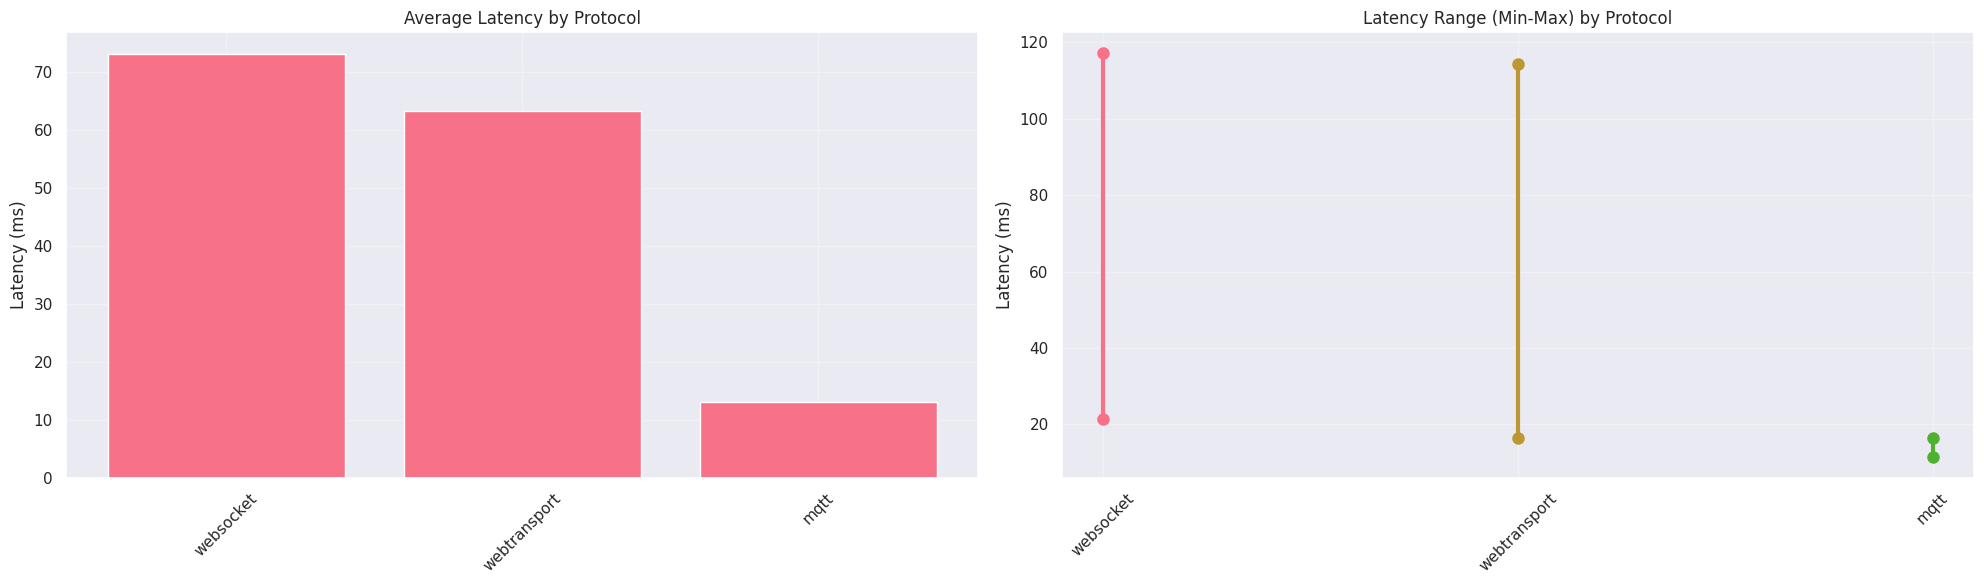

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Average latency by protocol
axes[0].bar(stats_df['protocol'], stats_df['avg'])
axes[0].set_title('Average Latency by Protocol')
axes[0].set_ylabel('Latency (ms)')
axes[0].tick_params(axis='x', rotation=45)

# Min-Max latency range
for i, row in stats_df.iterrows():
    axes[1].plot([row['protocol'], row['protocol']], [row['min'], row['max']], 
                   marker='o', linewidth=3, markersize=8)
axes[1].set_title('Latency Range (Min-Max) by Protocol')
axes[1].set_ylabel('Latency (ms)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 2.1 Time Series analysis of telemetry data

In [51]:
# Check for missing values in telemetry data
print("Missing values in telemetry data:")
print(f"MQTT: {telemetry_df['mqtt'].isna().sum()}")
print(f"WebTransport: {telemetry_df['wt'].isna().sum()}")
print(f"WebSocket: {telemetry_df['ws'].isna().sum()}")

# Check data shape and info
print(f"\nTelemetry data shape: {telemetry_df.shape}")
print(f"Sequence ID range: {telemetry_df['sequence_id'].min()} - {telemetry_df['sequence_id'].max()}")

# Display first few rows to understand the data structure
print("\nFirst 10 rows of telemetry data:")
print(telemetry_df.head(10))

Missing values in telemetry data:
MQTT: 2
WebTransport: 3
WebSocket: 2

Telemetry data shape: (68, 4)
Sequence ID range: 60 - 125

First 10 rows of telemetry data:
   sequence_id   mqtt      wt      ws
0           60  15.00   52.00  115.00
1           61  12.35   71.35  105.35
2           62  12.35   70.35  101.35
3           63  11.35   85.35  114.35
4           64  12.35   51.35   76.35
5           65  13.35   76.35  101.35
6           66  14.35   63.35   84.35
7           67  12.35   22.35   31.35
8           68  12.35  113.35   21.35
9           69  12.35  106.35  112.35


In [52]:
# Create a copy of the dataframe for interpolation
telemetry_clean = telemetry_df.copy()

# Sort by sequence_id to ensure proper interpolation order
telemetry_clean = telemetry_clean.sort_values('sequence_id').reset_index(drop=True)

# Interpolate missing values using linear interpolation
telemetry_clean['mqtt'] = telemetry_clean['mqtt'].interpolate(method='linear')
telemetry_clean['wt'] = telemetry_clean['wt'].interpolate(method='linear')
telemetry_clean['ws'] = telemetry_clean['ws'].interpolate(method='linear')


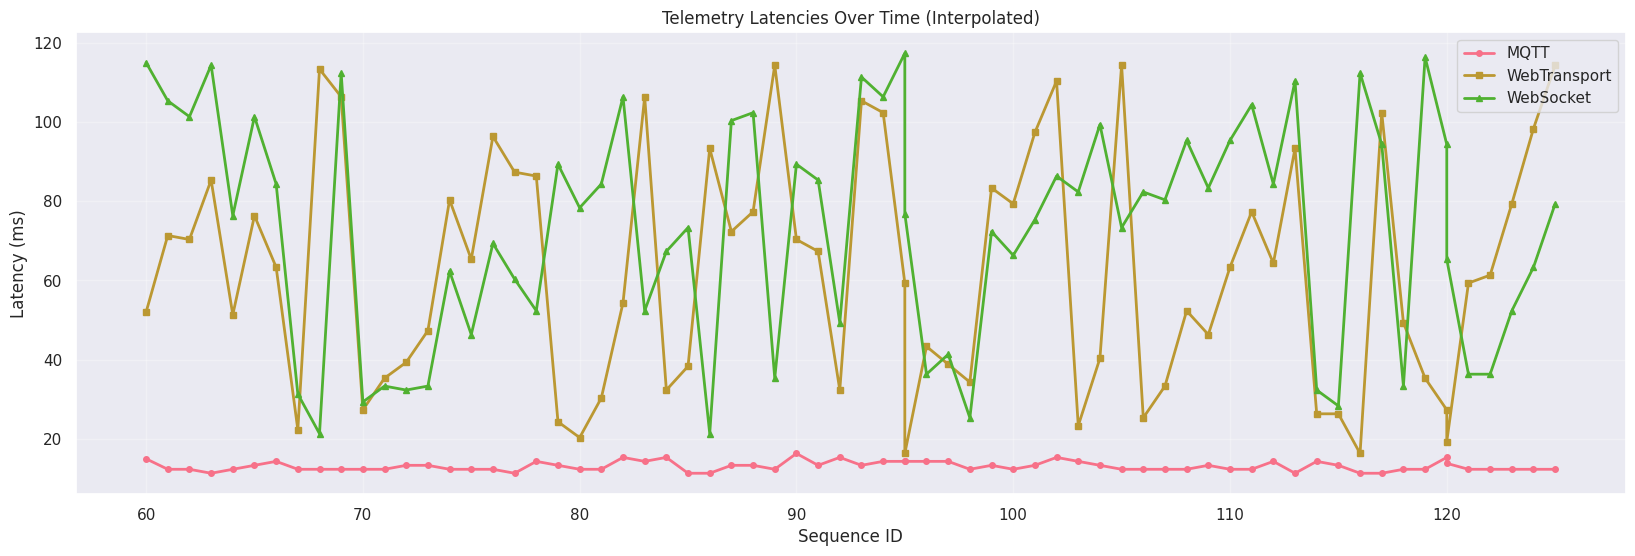

In [53]:
plt.figure(figsize=(20, 6))
plt.plot(telemetry_clean['sequence_id'], telemetry_clean['mqtt'], marker='o', label='MQTT', linewidth=2, markersize=4)
plt.plot(telemetry_clean['sequence_id'], telemetry_clean['wt'], marker='s', label='WebTransport', linewidth=2, markersize=4)
plt.plot(telemetry_clean['sequence_id'], telemetry_clean['ws'], marker='^', label='WebSocket', linewidth=2, markersize=4)
plt.xlabel('Sequence ID')
plt.ylabel('Latency (ms)')
plt.title('Telemetry Latencies Over Time (Interpolated)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

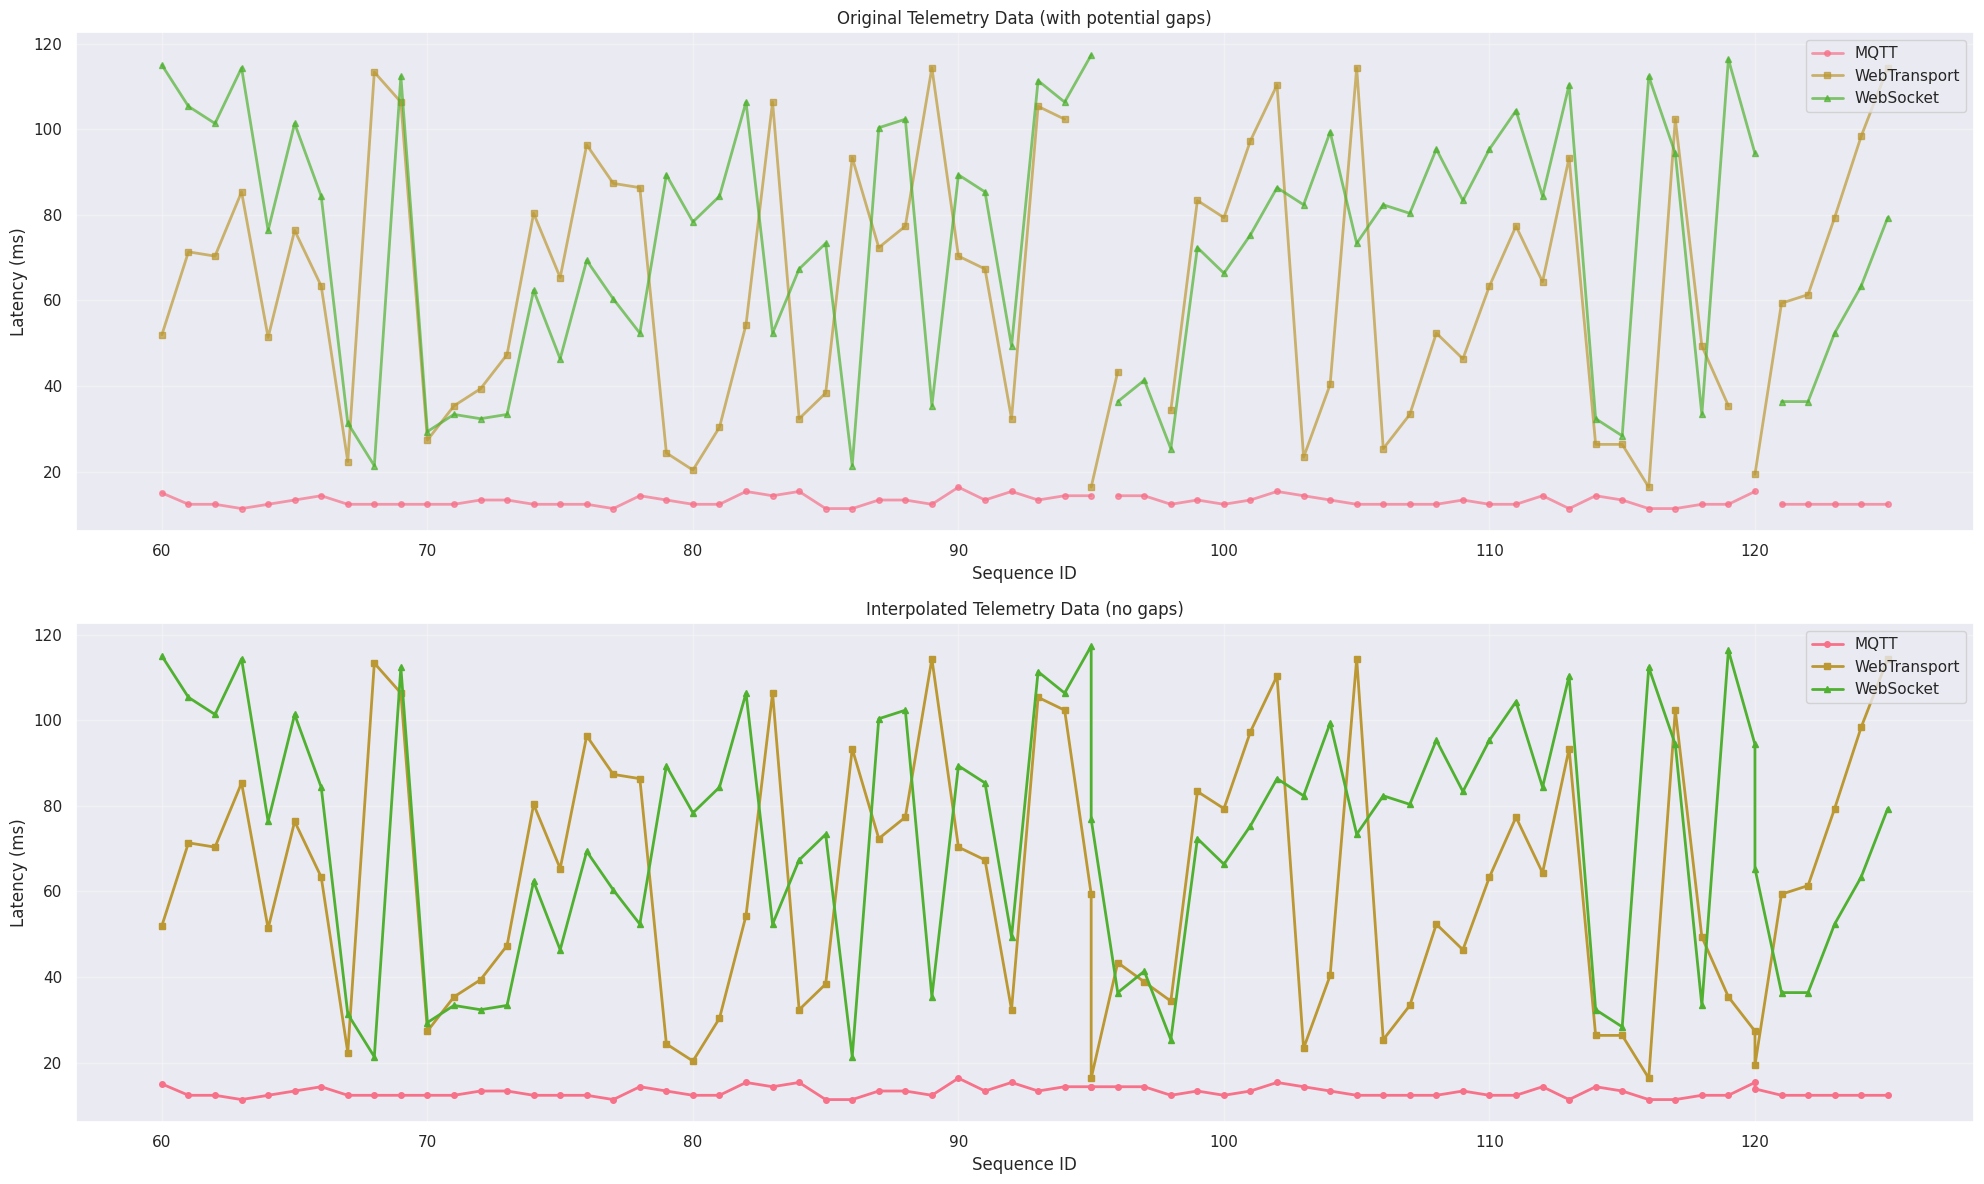

In [54]:
# Comparison: Original data with gaps vs Interpolated data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Original data (with potential gaps)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['mqtt'], marker='o', label='MQTT', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['wt'], marker='s', label='WebTransport', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['ws'], marker='^', label='WebSocket', linewidth=2, markersize=4, alpha=0.7)
ax1.set_xlabel('Sequence ID')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Original Telemetry Data (with potential gaps)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Interpolated data (no gaps)
ax2.plot(telemetry_clean['sequence_id'], telemetry_clean['mqtt'], marker='o', label='MQTT', linewidth=2, markersize=4)
ax2.plot(telemetry_clean['sequence_id'], telemetry_clean['wt'], marker='s', label='WebTransport', linewidth=2, markersize=4)
ax2.plot(telemetry_clean['sequence_id'], telemetry_clean['ws'], marker='^', label='WebSocket', linewidth=2, markersize=4)
ax2.set_xlabel('Sequence ID')
ax2.set_ylabel('Latency (ms)')
ax2.set_title('Interpolated Telemetry Data (no gaps)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.2 Cumulative Latency Analysis for telemetry data

In [55]:
# Create cumulative latency data
telemetry_clean_cumulative = telemetry_clean.copy()

# Calculate cumulative latencies for each protocol
telemetry_clean_cumulative['mqtt_cumulative'] = telemetry_clean_cumulative['mqtt'].cumsum()
telemetry_clean_cumulative['wt_cumulative'] = telemetry_clean_cumulative['wt'].cumsum()
telemetry_clean_cumulative['ws_cumulative'] = telemetry_clean_cumulative['ws'].cumsum()

print("Cumulative latency data created successfully!")
print(f"Shape: {telemetry_clean_cumulative.shape}")
print("\nFirst 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].head(10))
print("\nLast 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].tail(10))

Cumulative latency data created successfully!
Shape: (68, 7)

First 10 rows of cumulative data:
   sequence_id  mqtt_cumulative  wt_cumulative  ws_cumulative
0           60            15.00          52.00         115.00
1           61            27.35         123.35         220.35
2           62            39.70         193.70         321.70
3           63            51.05         279.05         436.05
4           64            63.40         330.40         512.40
5           65            76.75         406.75         613.75
6           66            91.10         470.10         698.10
7           67           103.45         492.45         729.45
8           68           115.80         605.80         750.80
9           69           128.15         712.15         863.15

Last 10 rows of cumulative data:
    sequence_id  mqtt_cumulative  wt_cumulative  ws_cumulative
58          117           775.30        3686.80        4390.80
59          118           787.65        3736.15        4424.15

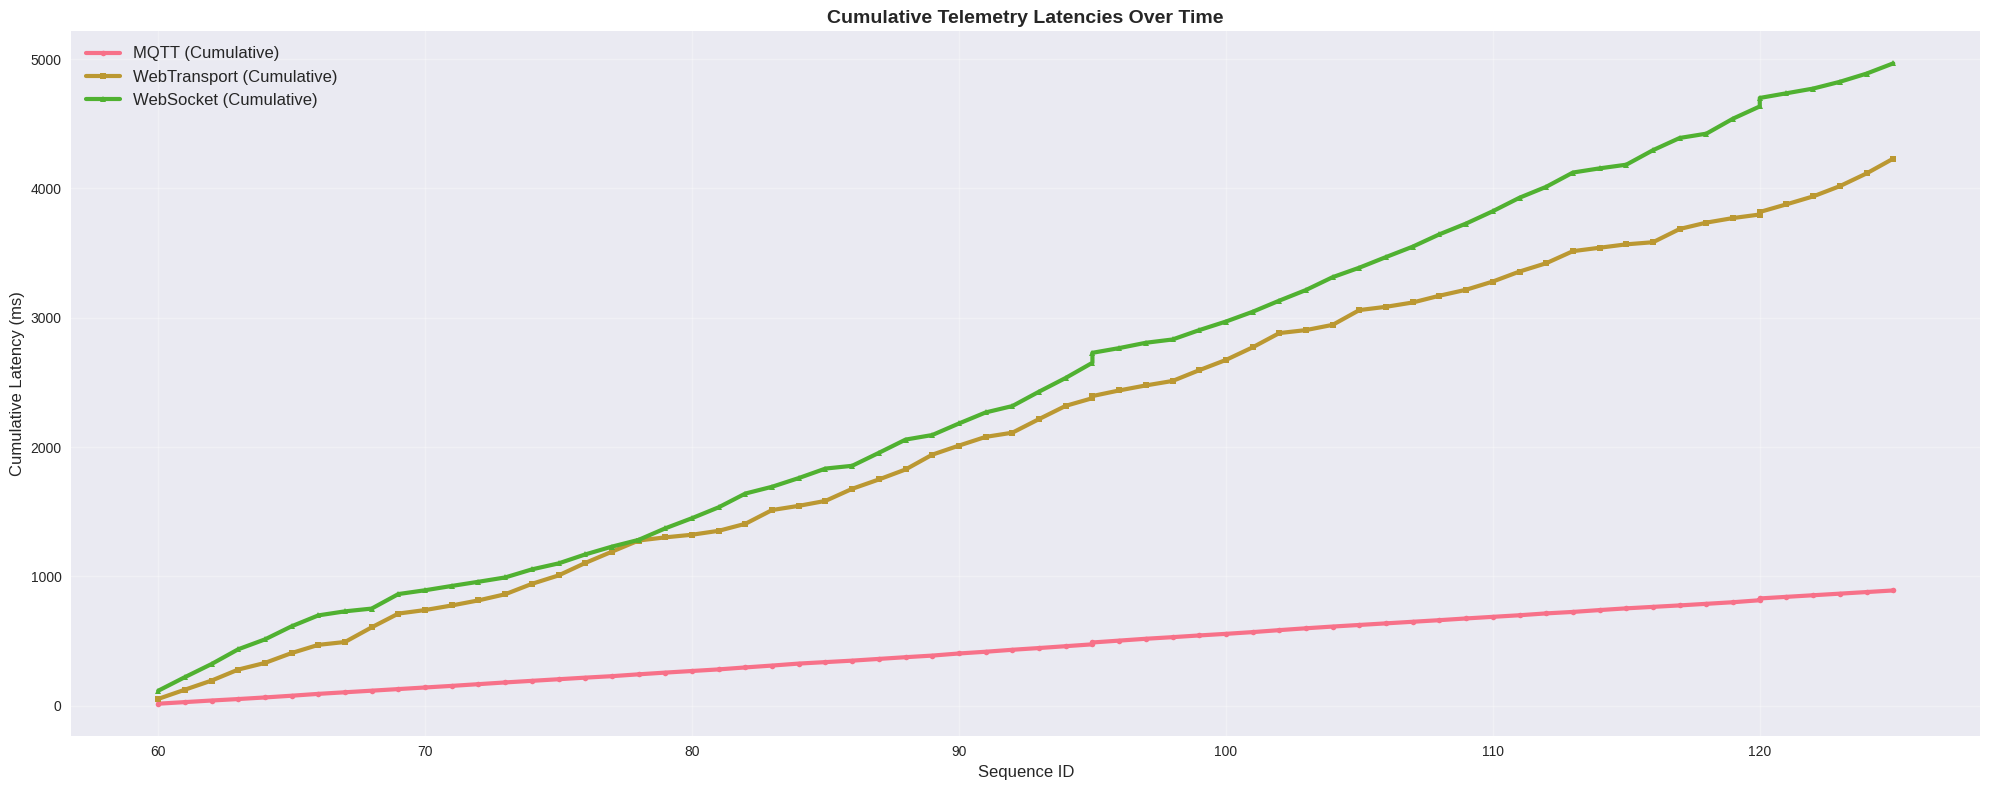

In [41]:
# Plot cumulative latencies
plt.figure(figsize=(20, 8))
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['mqtt_cumulative'],
         marker='o', label='MQTT (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['wt_cumulative'],
         marker='s', label='WebTransport (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['ws_cumulative'],
         marker='^', label='WebSocket (Cumulative)', linewidth=3, markersize=4)

plt.xlabel('Sequence ID', fontsize=12)
plt.ylabel('Cumulative Latency (ms)', fontsize=12)
plt.title('Cumulative Telemetry Latencies Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()